# Survival Analysis of PBTA splicing data
### Author: Shehbeel Arif
### Affiliation: Center for Data-driven Discovery in Biomedicine (D3b), The Children's Hospital of Philadelphia
### Contact: arifs2@chop.edu
### Goal: To find prognostic splicing sites that correlate with overall survival (OS) and progression-free survival (PFS)

In [1]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Modeling libraries
import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

# Survival Libraries
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
# Load OpenPBTA splicing dataset
#data_dir = "/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/Ammar_splicing/data/"
data_dir = "/Users/shehbeel/Documents/Ammar_splicing/data/"
results_dir = "/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/results/"

df = pd.read_csv(data_dir + "pan_cancer_splicing_SE.rg.gene.fitlered.uniq.txt", sep="\t", header=None)
header = pd.read_csv(data_dir + "splicing_header.txt", sep="\t")
meta = pd.read_csv(data_dir + "histologies.tsv", sep="\t", low_memory=False)

# Add header to splicing matrix
df.columns = header.columns
# Set 'Splice_ID' as index
df = df.set_index('Splice_ID')
# Transpose the matrix
tdf = df.T
# Make 'Splicing_ID' index as column and change name to 'Kids_First_Biospecimen_ID'
tdf = tdf.reset_index()
tdf = tdf.rename({'index':'Kids_First_Biospecimen_ID'}, axis=1)

# Merge meta data and splicing matrix
dfm = pd.merge(meta, tdf, on='Kids_First_Biospecimen_ID')

dfm

,Kids_First_Biospecimen_ID,sample_id,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,ZXDC_126441765-126441946_126439631-126439727_126459652-126459737,ZXDC_126441765-126441946_126439631-126439727_126461269-126462220,ZXDC_126441765-126441946_126439631-126439727_126461534-126462220,ZYX_143381557-143381779_143381344-143381409_143388488-143388658,ZYX_143382248-143382447_143381294-143381409_143382800-143383322,ZYX_143382248-143382447_143381360-143381779_143382800-143383322,ZYX_143382248-143382685_143381556-143381779_143382800-143383235,ZYX_143382593-143382685_143381556-143381779_143382800-143382925,ZYX_143382593-143382685_143382247-143382447_143382800-143382925,ZYX_143388219-143388339_143381344-143381409_143388488-143388500
0,BS_014EVM2D,7316-362,570113,PT_S21ZTKPS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BS_02NZT8CE,7316-1745,549619,PT_2BJF83GQ,RNA-Seq,Tumor,Solid Tissue,Progressive,Optic Pathway;Temporal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BS_03FT4S8B,7316-1671,654203,PT_5KRVE8E4,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BS_0448A413,7316-364,570114,PT_VHS5RM2K,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BS_044XZ8ST,7316-3570,711744,PT_QAX38GM7,RNA-Seq,Tumor,Solid Tissue,Progressive,Parietal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,BS_ZWR9W4FX,7316-1653,717103,PT_4RJ2EATN,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,BS_ZXYDSBM9,7316-739,731886,PT_R63RHJWX,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa;Ventricles,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,BS_ZZMYDZJW,7316-436,564451,PT_5M8A47WW,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1025,BS_ZZPBANDD,7316-1941,588347,PT_9YNQJZ5G,RNA-Seq,Tumor,Solid Tissue,Progressive,Temporal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Drop duplicates if present; A single 'sample_id' can have multiple 'Kids_First_Biospecimen_ID's
dfm = dfm.drop_duplicates(subset='sample_id')
# Drop NAs present in OS_survival column
dfms = dfm.dropna(subset=['OS_days', 'OS_status'])

dfms

,Kids_First_Biospecimen_ID,sample_id,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,ZXDC_126441765-126441946_126439631-126439727_126459652-126459737,ZXDC_126441765-126441946_126439631-126439727_126461269-126462220,ZXDC_126441765-126441946_126439631-126439727_126461534-126462220,ZYX_143381557-143381779_143381344-143381409_143388488-143388658,ZYX_143382248-143382447_143381294-143381409_143382800-143383322,ZYX_143382248-143382447_143381360-143381779_143382800-143383322,ZYX_143382248-143382685_143381556-143381779_143382800-143383235,ZYX_143382593-143382685_143381556-143381779_143382800-143382925,ZYX_143382593-143382685_143382247-143382447_143382800-143382925,ZYX_143388219-143388339_143381344-143381409_143388488-143388500
0,BS_014EVM2D,7316-362,570113,PT_S21ZTKPS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BS_02NZT8CE,7316-1745,549619,PT_2BJF83GQ,RNA-Seq,Tumor,Solid Tissue,Progressive,Optic Pathway;Temporal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BS_0448A413,7316-364,570114,PT_VHS5RM2K,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BS_044XZ8ST,7316-3570,711744,PT_QAX38GM7,RNA-Seq,Tumor,Solid Tissue,Progressive,Parietal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BS_052PZFMK,7316-1099,470025,PT_N3205P0D,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Frontal Lobe;Parietal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,BS_ZVZDDW2G,7316-2664,711710,PT_E3ADF4ZB,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Frontal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,BS_ZWR9W4FX,7316-1653,717103,PT_4RJ2EATN,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,BS_ZXYDSBM9,7316-739,731886,PT_R63RHJWX,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa;Ventricles,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,BS_ZZMYDZJW,7316-436,564451,PT_5M8A47WW,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

# HGAT only

In [4]:
# Subset HGAT samples
hdf = dfms[dfms['short_histology'] == 'HGAT']
hdf

,Kids_First_Biospecimen_ID,sample_id,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,ZXDC_126441765-126441946_126439631-126439727_126459652-126459737,ZXDC_126441765-126441946_126439631-126439727_126461269-126462220,ZXDC_126441765-126441946_126439631-126439727_126461534-126462220,ZYX_143381557-143381779_143381344-143381409_143388488-143388658,ZYX_143382248-143382447_143381294-143381409_143382800-143383322,ZYX_143382248-143382447_143381360-143381779_143382800-143383322,ZYX_143382248-143382685_143381556-143381779_143382800-143383235,ZYX_143382593-143382685_143381556-143381779_143382800-143382925,ZYX_143382593-143382685_143382247-143382447_143382800-143382925,ZYX_143388219-143388339_143381344-143381409_143388488-143388500
5,BS_052PZFMK,7316-1099,470025,PT_N3205P0D,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Frontal Lobe;Parietal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,BS_0C7VZC0A,7316-2176,588280,PT_VAJN5QP8,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Basal Ganglia;Optic Pathway;Temporal Lobe;Vent...,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,BS_0RQ4P069,7316-1746,739942,PT_C2D4JXS1,RNA-Seq,Tumor,Derived Cell Line,Initial CNS Tumor,Cerebellum/Posterior Fossa,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,BS_0VXZCRJS,7316-466,401561,PT_40HTPY49,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Thalamus,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,BS_0ZA67BBC,A12748,A12764,PT_VPEMAQBN,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Pons/Brainstem,Not Reported,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,BS_Z8YZ6QGS,7316-2307,731934,PT_S0Q27J13,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Parietal Lobe,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,BS_ZD5HN296,7316-445,401741,PT_89XRZBSG,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,BS_ZF6BSFNF,A15170,A15183,PT_NWYSD53S,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Pons/Brainstem,Not Reported,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,BS_ZV1P6W9C,7316-1068,574556,PT_ZVYRFGEN,RNA-Seq,Tumor,Solid Tissue,Progressive,Brain Stem-Medulla;Brain Stem- Midbrain/Tectum...,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into Training and Testing Set

In [5]:
# Select only splicing sites columns for X feature matrix
X = hdf.iloc[:,46:]
# Select only OS_status and OS_days columns for y labels
y = hdf[['OS_status', 'OS_days']]
# Convert 'OS_status' to TRUE and FALSE
y['OS_status'] = y['OS_status'].map({'DECEASED':True, 'LIVING':False})
#X.head(5)
y

/var/folders/dt/gtzg6wys47bbxzctx45shfkm0000gn/T/ipykernel_11694/4101433226.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['OS_status'] = y['OS_status'].map({'DECEASED':True, 'LIVING':False})


,OS_status,OS_days
5,True,2125.0
13,False,1776.0
19,True,132.0
24,True,1569.0
30,True,552.0
...,...,...
1001,True,1219.0
1004,False,5100.0
1006,True,854.0
1016,True,155.0


In [6]:
# Convert y (boolean censor and OS_surival) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_status': 'bool', 'OS_days':'f8'})
y

rec.array([( True, 2.125e+03), (False, 1.776e+03), ( True, 1.320e+02),
           ( True, 1.569e+03), ( True, 5.520e+02), ( True, 6.380e+02),
           ( True, 1.003e+03), ( True, 7.024e+03), ( True, 7.280e+02),
           ( True, 7.040e+02), ( True, 2.410e+02), ( True, 8.281e+03),
           ( True, 1.139e+03), ( True, 2.730e+02), ( True, 3.700e+01),
           ( True, 1.747e+03), ( True, 3.020e+02), ( True, 1.003e+03),
           ( True, 3.890e+02), ( True, 6.930e+02), ( True, 2.220e+02),
           (False, 5.150e+02), ( True, 2.600e+02), (False, 5.100e+03),
           ( True, 4.820e+02), ( True, 8.550e+02), (False, 3.313e+03),
           ( True, 2.760e+02), ( True, 3.580e+02), ( True, 2.890e+02),
           ( True, 4.200e+02), ( True, 2.730e+02), ( True, 5.150e+02),
           ( True, 9.910e+02), ( True, 2.681e+03), ( True, 2.440e+02),
           ( True, 5.150e+02), ( True, 2.310e+02), ( True, 3.460e+02),
           ( True, 8.440e+02), ( True, 2.250e+02), ( True, 7.500e+01),
      

### Normalize Data

In [7]:
# Normalize the splicing features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fits and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Add column names back into normalized dataframe
Xs.columns = X.columns

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])

Xs

,A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857,A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857,AAAS_53314751-53314849_53314297-53314441_53315093-53315140,AADAT_170078509-170078583_170073135-170073345_170087115-170087248,AAGAB_67231814-67231897_67209461-67209544_67235978-67236068,AAK1_69480860-69480961_69465845-69466551_69495984-69496080,AAK1_69480860-69480961_69465845-69466551_69505568-69505673,AAMDC_77855345-77855482_77842478-77842628_77869721-77869817,AAMDC_77869722-77869817_77842478-77842628_77884779-77884916,AARS1_70258033-70258217_70255727-70255836_70258979-70259186,...,ZSWIM8_73800120-73800194_73799376-73799490_73800295-73800472,ZW10_113757662-113757853_113748256-113748420_113758553-113758706,ZXDC_126441765-126441946_126439631-126439727_126459652-126459737,ZXDC_126441765-126441946_126439631-126439727_126461269-126462220,ZXDC_126441765-126441946_126439631-126439727_126461534-126462220,ZYX_143381557-143381779_143381344-143381409_143388488-143388658,ZYX_143382248-143382447_143381360-143381779_143382800-143383322,ZYX_143382248-143382685_143381556-143381779_143382800-143383235,ZYX_143382593-143382685_143381556-143381779_143382800-143382925,ZYX_143382593-143382685_143382247-143382447_143382800-143382925
0,-0.222649,-0.342178,1.701417,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
1,-0.222649,-0.342178,1.563743,-0.081111,-0.081111,1.924269,2.569809,1.670769,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
2,-0.222649,3.659371,1.568939,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
3,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
4,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,-0.252446,-0.504262,1.670769,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
149,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
150,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,-0.252446,-0.504262,-0.476148,-0.201868,-0.115086,...,-0.081111,6.261884,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805
151,-0.222649,-0.342178,-0.633833,-0.081111,-0.081111,5.214190,3.885225,-0.476148,-0.201868,-0.115086,...,-0.081111,-0.163729,-0.081111,-0.115087,-0.141411,-0.14142,-0.201925,-0.141404,-0.141274,-0.163805


---

## Grid-Search to find optimal model parameters and conduct feature selection

In [8]:
penalty_factor = np.ones(Xs.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

array([0., 0., 0., ..., 1., 1., 1.])

### Model #1

In [9]:
def plot_alphas(gcv, model_num):
    cv_results = pd.DataFrame(gcv.cv_results_)
    
    alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
    ax.set_xscale("log")
    ax.set_title(f"Model# {model_num}; CI : {max(mean)}")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

In [10]:
###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_models/coxnet_feb22/gcv_splicing_v{version}.pkl"


joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/shehbeel/Documents/Ammar_splicing/survival_modeling/saved_stats/coxnet_feb22/stats_splicing_v{version}.pkl")


results



/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_e

l1 best : 0.2
 non-zero: 265


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to 0.5.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxnet.py", line 249, in f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
172,0.115331,0.000832,0.049984,0.000220,[0.4],0.2,"{'coxnetsurvivalanalysis__alphas': [0.4], 'cox...",0.633523,0.663805,0.667780,0.633383,0.649623,0.016231,1
274,0.134476,0.001956,0.050313,0.000326,[0.65],0.05,"{'coxnetsurvivalanalysis__alphas': [0.65], 'co...",0.636364,0.680973,0.634391,0.631893,0.645905,0.020308,2
358,0.131799,0.001135,0.050267,0.000296,[0.8500000000000001],0.05,{'coxnetsurvivalanalysis__alphas': [0.85000000...,0.639205,0.679542,0.624374,0.634873,0.644499,0.020939,3
253,0.135430,0.002059,0.050404,0.000834,[0.6000000000000001],0.05,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.620739,0.685265,0.632721,0.636364,0.643772,0.024643,4
295,0.134334,0.002418,0.050885,0.000495,[0.7000000000000001],0.05,{'coxnetsurvivalanalysis__alphas': [0.70000000...,0.640625,0.675250,0.622705,0.634873,0.643363,0.019514,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.109760,0.000171,0.049904,0.000057,[0.5],0.65,"{'coxnetsurvivalanalysis__alphas': [0.5], 'cox...",0.528409,0.480687,0.557596,0.572280,0.534743,0.034977,415
344,0.109834,0.000275,0.049798,0.000238,[0.8],0.4,"{'coxnetsurvivalanalysis__alphas': [0.8], 'cox...",0.526989,0.472818,0.557596,0.572280,0.532421,0.038094,417
184,0.109500,0.000590,0.050035,0.000372,[0.4],0.8,"{'coxnetsurvivalanalysis__alphas': [0.4], 'cox...",0.529830,0.474249,0.557596,0.567809,0.532371,0.036321,418
263,0.109558,0.000307,0.049862,0.000219,[0.6000000000000001],0.55,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.528409,0.469242,0.557596,0.573770,0.532254,0.039847,419


Number of non-zero coefficients: 265


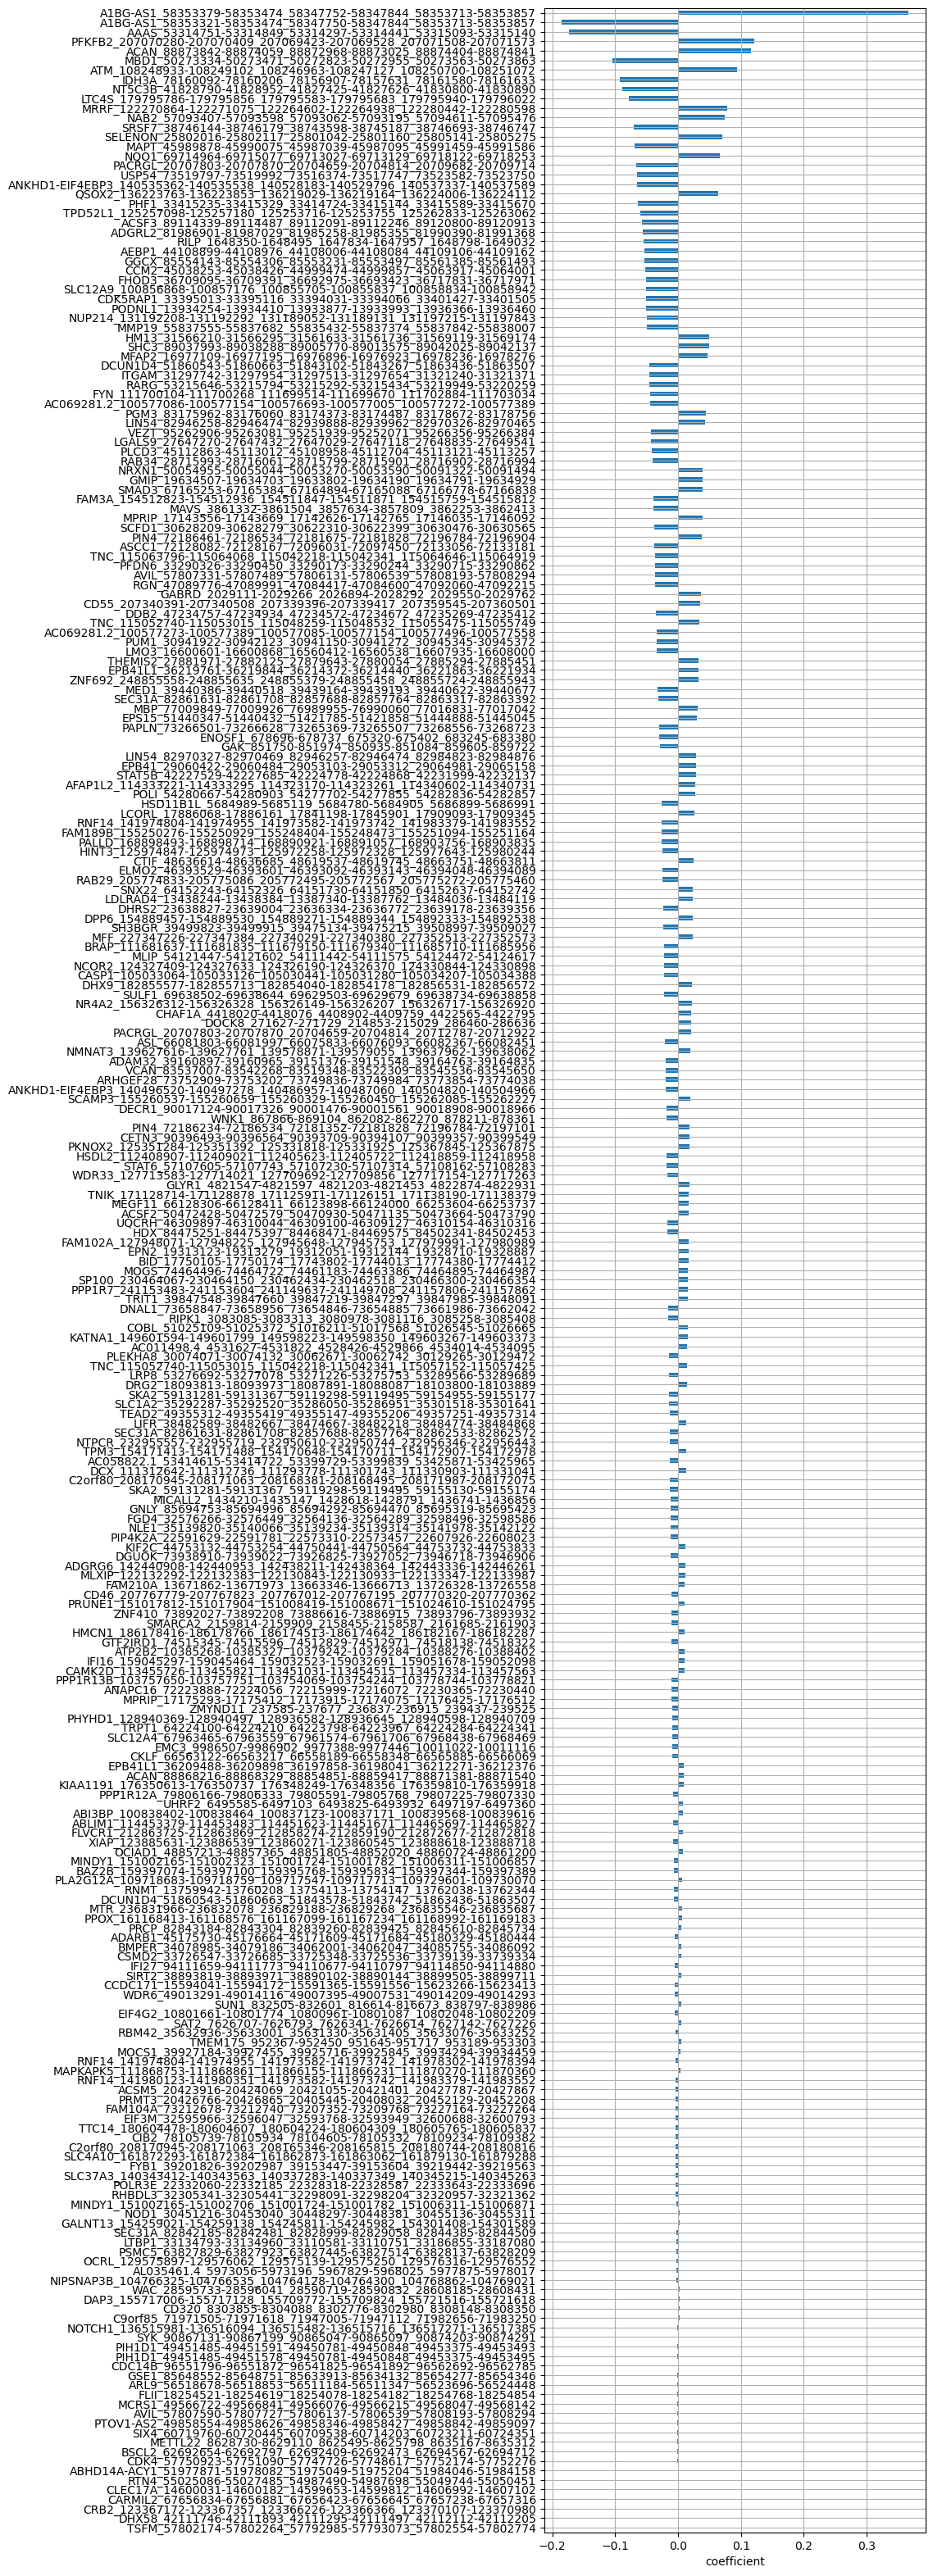

In [21]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [22]:
#non_zero_coefs.abs().sort_values("coefficient", key=abs, ascending=False)

,coefficient
A1BG-AS1_58353379-58353474_58347752-58347844_58353713-58353857,0.366008
A1BG-AS1_58353321-58353474_58347750-58347844_58353713-58353857,0.185301
AAAS_53314751-53314849_53314297-53314441_53315093-53315140,0.173633
PFKFB2_207070280-207070409_207069423-207069528_207071508-207071573,0.120647
ACAN_88873842-88874059_88872968-88873025_88874404-88874841,0.115708
...,...
CLEC17A_14600031-14600182_14599653-14599812_14606992-14607102,0.000561
CARMIL2_67656834-67656881_67656423-67656645_67657238-67657316,0.000427
CRB2_123367172-123367357_123366226-123366366_123370107-123370980,0.000379
DHX58_42111746-42111893_42111295-42111497_42112112-42112205,0.000368


In [23]:
# Export top ranked prognostic splicing sites
ranked_prognostic_splicing_sites = non_zero_coefs.sort_values("coefficient", key=abs, ascending=False)
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.reset_index()
ranked_prognostic_splicing_sites = ranked_prognostic_splicing_sites.rename(columns={'index':'splicing_site'})
ranked_prognostic_splicing_sites.to_csv(results_dir + "ranked_prognostic_splicing_sites.csv", index=False)

---

# Re-create model with optimized parameters found from Grid-Search Cross-Validation

In [26]:
coxnet = CoxnetSurvivalAnalysis(alphas=[0.4], l1_ratio=0.2)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

0.9538167243578065


Comment: Using all the splicing site features, we get a concordance index of ~0.95, which can be interpreted as the AUC for an ML model for predicting Overall Survival.

In [27]:
# Look at ranking of all the splcing sites
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients']).sort_values('coefficients')

,coefficients
IDH3A_78160092-78160206_78156907-78157631_78161580-78161633,-0.110023
MBD1_50273334-50273471_50272823-50272955_50273563-50273863,-0.095470
LTC4S_179795786-179795856_179795583-179795683_179795940-179796022,-0.085174
NT5C3B_41828790-41828952_41827425-41827626_41830800-41830890,-0.079166
ACSF3_89114339-89114487_89112091-89112246_89120800-89120913,-0.078704
...,...
MRRF_122270864-122271075_122264602-122264938_122280442-122280598,0.075627
ATM_108248933-108249102_108246963-108247127_108250700-108251072,0.086174
NQO1_69714964-69715077_69713027-69713129_69718122-69718253,0.099119
ACAN_88873842-88874059_88872968-88873025_88874404-88874841,0.117505


---

# Create univariate cox model using the top-ranked splicing site found

In [28]:
coxnet_specific = CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)
coxnet_specific.fit(Xs[['IDH3A_78160092-78160206_78156907-78157631_78161580-78161633']], y)
print(coxnet_specific.score(Xs[['IDH3A_78160092-78160206_78156907-78157631_78161580-78161633']],y))

0.5390781563126252


---

## Which variable is the most predictive of OS?

In [29]:
# import numpy as np
# print("Any NA values? ", np.any(np.isnan(Xs)))
# print("Any infinity values? ", np.all(np.isfinite(Xs)))

In [30]:
# # Replace infinite updated data with nan
# Xs.replace([np.inf, -np.inf], np.nan, inplace=True)
# # Drop rows with NaN
# Xs.dropna(inplace=True)
#Xs.fillna(999, inplace=True)
# print(Xs)

In [31]:
# def fit_and_score_features(X, y):
#     n_features = X.shape[1]
#     scores = np.empty(n_features)
#     m = CoxPHSurvivalAnalysis(alpha=1e-4, verbose=10)
#     for j in range(n_features):
#         Xj = X[:, j:j+1]
#         m.fit(Xj, y)
#         scores[j] = m.score(Xj, y)d
#     return scores

# scores = fit_and_score_features(Xs.values, y)
# pd.Series(scores, index=Xs.columns).sort_values(ascending=False)

In [32]:
#pd.DataFrame(scores, index=Xs.columns, columns=['c-index']).sort_values('c-index', ascending=False)

---